In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import * 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pathlib import Path
from skimage.io import imread

In [3]:
import os

# Construir la ruta a partir del directorio base del usuario
base_path = os.path.expanduser('~/Escritorio/Acustic/img/Spectrograms')

# Recorrer los archivos en la carpeta 'Spectrograms'
for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(5)_0120.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(4)_0495.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(3)_0199.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(4)_0319.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(2)_0067.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(4)_0129.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(3)_0326.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(3)_0022.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(1)_0150.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(4)_0336.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(4)_0506.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covid(3)_0054.jpg
/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/covi

In [4]:
def create_dataset(img_folders,IMG_WIDTH,IMG_HEIGHT, label):
    img_data_array=[]
    class_name=[]
    n=0
    for dirname, _, filenames in os.walk(img_folders):
        for filename in filenames:
            img_path= os.path.join(dirname, filename)
            # read the image
            image = cv2.imread(img_path)
            # BGR is converted to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_WIDTH,IMG_HEIGHT))
            # convert image to numpy array
            image = np.array(image)
            image = image.astype('float32')
            # normalization
            image /= 255
            img_data_array.append(image)
            class_name.append(label)
            n+=1
                
    return img_data_array, class_name, n

In [5]:


IMG_WIDTH = 244
IMG_HEIGHT = 244

noncovid_dir = '/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Non-Covid/'
covid_dir = '/home/yvan/Escritorio/Acustic/img/Spectrograms/(Real) Covid/'

noncovid_img, noncovid_target, num_noncovid = create_dataset(noncovid_dir, IMG_WIDTH, IMG_HEIGHT, 'noncovid')
covid_img, covid_target, num_covid = create_dataset(covid_dir, IMG_WIDTH, IMG_HEIGHT, 'covid')



In [6]:
X = noncovid_img + covid_img
y = noncovid_target + covid_target
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

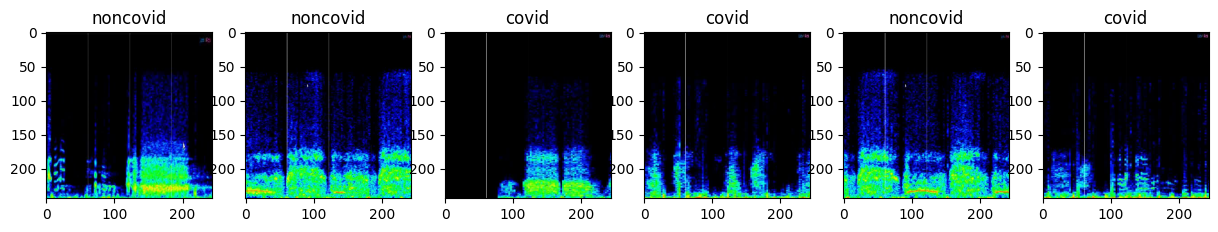

In [17]:
plt.figure(figsize=(15,5))
for i in range(6):
    ax=plt.subplot(1,6,(i+1))
    plt.imshow(X[i])
    ax.title.set_text(y[i])



In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear el generador de imágenes
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normaliza y divide en entrenamiento/validación

# Directorio base donde están las imágenes
base_dir = '/home/yvan/Escritorio/Acustic/img/Spectrograms/'

# Generador de datos de entrenamiento
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,           # Tamaño de los lotes
    class_mode='binary',     # Etiquetas binarias para 'covid' y 'noncovid'
    subset='training'
)

# Generador de datos de validación
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 5349 images belonging to 6 classes.
Found 1335 images belonging to 6 classes.


In [20]:
def serialize_example(image, label):
    # Convertir la etiqueta de texto a un entero (0 o 1)
    label_int = 0 if label == 'noncovid' else 1

    feature = {
        'image': _bytes_feature(image),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label_int]))  # Usar label_int en lugar de label
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Crear el archivo TFRecord
with tf.io.TFRecordWriter('dataset.tfrecord') as writer:
    for img, label in zip(X, y):  # X e y son tus listas de imágenes y etiquetas
        example = serialize_example(img, label)
        writer.write(example)
